In [1]:
import numpy as np 
import pandas as pd 
import optuna 
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score,accuracy_score, confusion_matrix, classification_report,precision_score,f1_score,average_precision_score
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [3]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [4]:
cat_features = [X.columns.get_loc(c) for c in ["Sex", "Embarked", "Title"]]

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
def objective(trial: optuna.Trial) ->float:
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0,
        #Гиперпараметры
        "iterations":trial.suggest_int("iterations", 300, 1500),
        "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.2,log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        #регуляризация
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
    }
    recalls = []
    for train_idx,val_idx in cv.split(X,y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
        y_pred = (model.predict_proba(val_pool)[:, 1] >= 0.5).astype(int)
        recalls.append(recall_score(y_val, y_pred))
    return float(np.mean(recalls))    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best CV recall:", study.best_value)
print("Best params:", study.best_params)
    

[I 2025-12-26 01:56:31,474] A new study created in memory with name: no-name-9b963672-8f2b-4263-8ef1-2328fdb7d279
[I 2025-12-26 01:56:41,748] Trial 0 finished with value: 0.6956902356902358 and parameters: {'iterations': 479, 'learning_rate': 0.01057908023316668, 'depth': 9, 'l2_leaf_reg': 10.102442461291984, 'random_strength': 1.0061236624198897, 'subsample': 0.7918882843270343, 'colsample_bylevel': 0.953957148932137}. Best is trial 0 with value: 0.6956902356902358.
[I 2025-12-26 01:56:48,716] Trial 1 finished with value: 0.6922558922558922 and parameters: {'iterations': 550, 'learning_rate': 0.014081327307449489, 'depth': 5, 'l2_leaf_reg': 2.433799256824035, 'random_strength': 2.3723097265905575e-05, 'subsample': 0.6396321653752729, 'colsample_bylevel': 0.8971885108024358}. Best is trial 0 with value: 0.6956902356902358.
[I 2025-12-26 01:57:17,141] Trial 2 finished with value: 0.6996632996632995 and parameters: {'iterations': 1391, 'learning_rate': 0.0323685384556396, 'depth': 10, 'l

Best CV recall: 0.7472053872053872
Best params: {'iterations': 896, 'learning_rate': 0.015476047378952085, 'depth': 9, 'l2_leaf_reg': 2.6635454391364344, 'random_strength': 8.411361470061176e-08, 'subsample': 0.8936210075536379, 'colsample_bylevel': 0.6215966493986136}


In [20]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()


In [21]:
best_params = study.best_params
final_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": 100,
    **best_params
}

In [22]:
train_pool = Pool(X, y, cat_features=cat_features)
test_pool  = Pool(X_test, y_test, cat_features=cat_features)

In [23]:
final_model = CatBoostClassifier(**final_params)
final_model.fit(train_pool)

0:	total: 27.5ms	remaining: 24.6s
100:	total: 2.89s	remaining: 22.8s
200:	total: 5.66s	remaining: 19.6s
300:	total: 8.42s	remaining: 16.7s
400:	total: 11s	remaining: 13.6s
500:	total: 13.5s	remaining: 10.7s
600:	total: 16.1s	remaining: 7.89s
700:	total: 18.6s	remaining: 5.19s
800:	total: 21.1s	remaining: 2.51s
895:	total: 23.7s	remaining: 0us


In [31]:
y_pred = final_model.predict(X_test)

In [32]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8212290502793296
Confusion matrix:
 [[99 11]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [33]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.8212290502793296
Доля ошибочных классификаций: 0.17877094972067042


Text(50.722222222222214, 0.5, 'True Label')

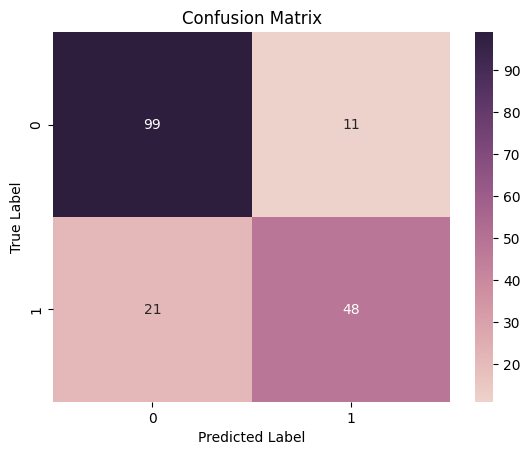

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [35]:
precision = precision_score(y_test, y_pred)
print(precision)

0.8135593220338984


In [36]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.75


In [37]:
average_precision_score(y_test, y_pred)

0.6832727467342932